In [128]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.patches as mpatches

In [129]:
POI_FILENAME = "../data/poi-paris.pkl"
parismap = mpimg.imread('../data/paris-48.806-2.23--48.916-2.48.jpg')
## coordonnees GPS de la carte
xmin, xmax = 2.23, 2.48  # coord_x min et max
ymin, ymax = 48.806, 48.916  # coord_y min et max
coords = [xmin, xmax, ymin, ymax]
coords = np.array([xmin, xmax, ymin, ymax])

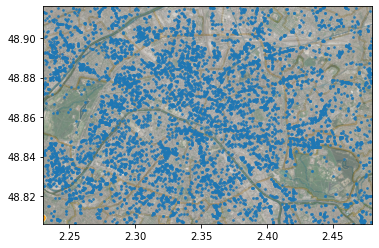

In [130]:
plt.ion()
# Liste des POIs : furniture_store, laundry, bakery, cafe, home_goods_store, clothing_store, atm, lodging, night_club, convenience_store, restaurant, bar
# La fonction charge la localisation des POIs dans geo_mat et leur note.
geo_rest, notes = load_poi("restaurant")

# Affiche la carte de Paris
show_img()
# Affiche les POIs
plt.scatter(geo_rest[:,0],geo_rest[:,1],alpha=0.8,s=3)

In [131]:
class Density(object):
    def fit(self,data):
        pass
    def predict(self,data):
        pass
    def score(self,data):
        #A compléter : retourne la log-vraisemblance
        y = self.predict(data) + 10e-10
        return np.sum(np.log(y))


# Méthode par histogramme

In [142]:
class Histogramme(Density):
    def __init__(self,steps=10):
        Density.__init__(self)
        self.steps = steps
    
    def fit(self,x):

        self.histogram = np.array(np.histogramdd(x, bins=self.steps))
        
        self.volume = ((xmax-xmin)*(ymax-ymin))/(self.steps**2)
        self.histogram[0]/=(len(x)*self.volume)
    
    def to_bin(self,x):
        l = ((x - coords[[0,2]])/(coords[[1,3]] - coords[[0,2]]))
        l *= self.steps
        return np.intc(np.floor(l))
        
    
    def predict(self,x):
        coord = self.to_bin(x)
        return self.histogram[0][coord[:,0],coord[:,1]]


In [145]:
def histo(geo_mat, start, end, step):
    X_train, X_test = train_test_split(geo_mat, test_size=0.2, random_state=None)
    s_test= []
    s_train= []
    for p in range(start,end,step):    
        h = Histogramme(p)
        h.fit(X_train)
        score = h.score(X_test)
        s_test += [score]
        score = h.score(X_train)
        s_train += [score]
       
    _, ax = plt.subplots(ncols=2,nrows=1,figsize=(15, 5))
    
    ax[0].set_title("Evolution de la vraissemblance par rapport au nombre de bins. (Test)")
    ax[0].set_ylabel("Vraissemblance")
    ax[0].set_xlabel("Nombre de bins")
    ax[0].plot(range(start,end,step),s_test,color="red")
    
    
    ax[1].set_title("Evolution de la vraissemblance par rapport au nombre de bins. (Train)")
    ax[1].set_ylabel("Vraissemblance")
    ax[1].set_xlabel("Nombre de bins")
    ax[1].plot(np.arange(start,end,step),s_train,color="blue")
    plt.show()
    

<ipython-input-142-89da9c2c3ac6>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.histogram = np.array(np.histogramdd(x, bins=self.steps))


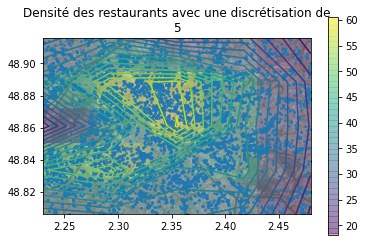

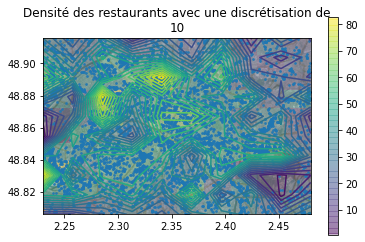

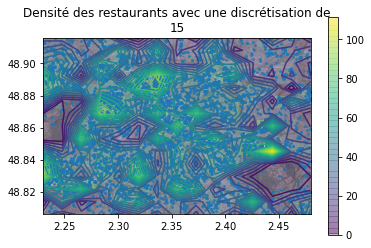

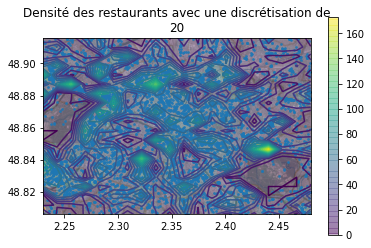

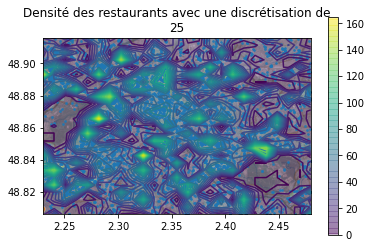

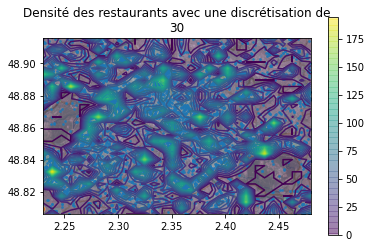

In [147]:
# Ici on va afficher la densité des restaurants avec plusieurs discrétisations
start = 5
end = 31
pas = 5
plt.close()
for i in range(start,end,pas):
    h = Histogramme(i)
    h.fit(geo_rest)
    title = "Densité des restaurants avec une discrétisation de\n" + str(i)
    show_density(h, geo_rest, i, log=False, title = title)

In [ ]:
# TODO : COMMENTER LES RESULTATS

<ipython-input-142-89da9c2c3ac6>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.histogram = np.array(np.histogramdd(x, bins=self.steps))


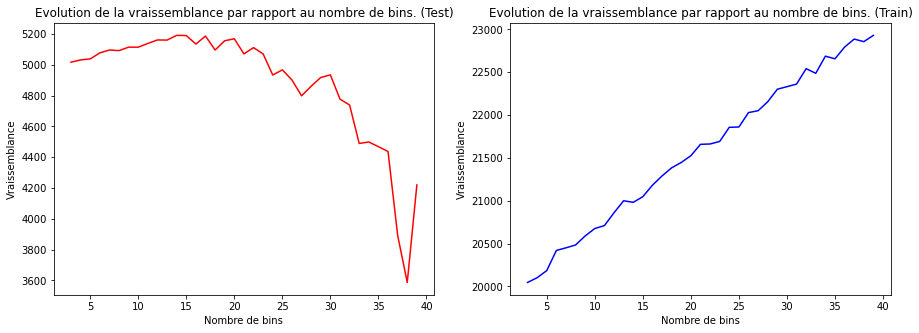

In [146]:
histo(geo_rest, 3, 40, 1)

In [ ]:
# TODO : COMMENTER LES RESULTATS

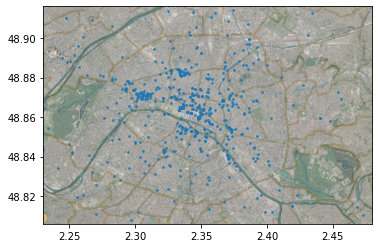

In [148]:
geo_night, _ = load_poi("night_club")

# Affiche la carte de Paris
show_img()
# Affiche les POIs
plt.scatter(geo_night[:,0],geo_night[:,1],alpha=0.8,s=3)

<ipython-input-142-89da9c2c3ac6>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.histogram = np.array(np.histogramdd(x, bins=self.steps))


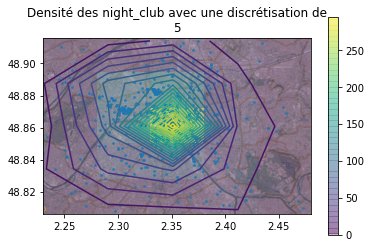

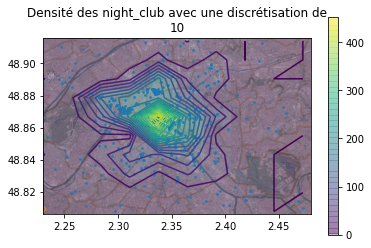

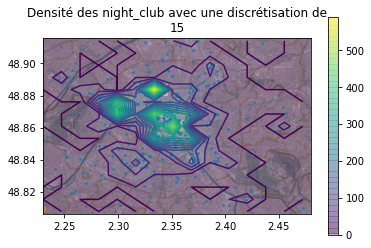

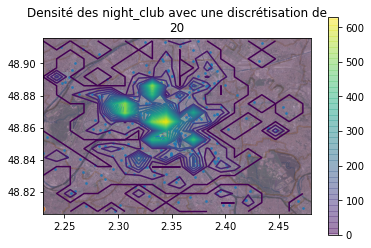

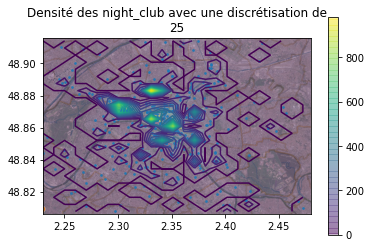

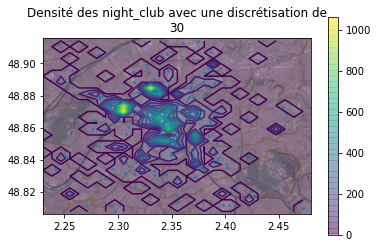

In [150]:
# Ici on va afficher la densité des night_clubs avec plusieurs discrétisations
start = 5
end = 31
pas = 5
plt.close()
for i in range(start,end,pas):
    h = Histogramme(i)
    h.fit(geo_night)
    title = "Densité des night_club avec une discrétisation de\n" + str(i)
    show_density(h, geo_night, i, log=False, title = title)

In [ ]:
# TODO : COMMENTER LES RESULTATS

<ipython-input-142-89da9c2c3ac6>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.histogram = np.array(np.histogramdd(x, bins=self.steps))


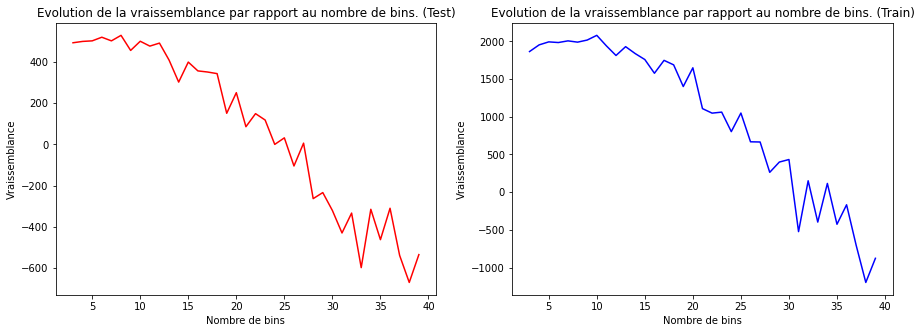

In [149]:
histo(geo_night, 3, 40, 1)

In [ ]:
# TODO : COMMENTER LES RESULTATS

# Méthodes à noyaux

In [151]:
class KernelDensity(Density):
    def __init__(self,kernel=None,sigma=0.1):
        Density.__init__(self)
        self.kernel = kernel
        self.sigma = sigma
    def fit(self,x):
        self.x = x
    def predict(self,data):
        #A compléter : retourne la densité associée à chaque point de data
        l = []
        for d in data:
            l.append(np.sum(self.kernel((d - self.x)/self.sigma)))
        
        l = np.array(l)
        r = 1/ (len(self.x)*(self.sigma**len(data[0])))
        return r*l
        
 
def kernel_uniform(data):
    res = np.all(abs(data) <= 1 / 2, 1)
    return np.multiply(res,1)
def kernel_gaussian(data):
    return (2*np.pi)**(-len(data[0])/2)*np.exp(-0.5*np.sum(data**2,axis=1))

In [154]:
def kernel_show(geo_mat, sigma = 0.001, start = 0.01, end = 0.1, step = 0.01 , kernel = kernel_gaussian):
    X_train, X_test = train_test_split(geo_mat, test_size=0.2, random_state=42)
    s_test = []
    s_train = []
    for sigma in np.arange(start,end,step):    
        d = KernelDensity(kernel=kernel, sigma = sigma)
        d.fit(X_train)
        score = d.score(X_test)
        s_test += [score]
        #print(s_test)
        score = d.score(X_train)
        s_train += [score]
        #print(s_train)
        
    _, ax = plt.subplots(ncols=2,nrows=1,figsize=(15, 5))
    
    ax[0].set_title("Evolution de la vraissemblance en fonction de sigma. (Test)")
    ax[0].set_ylabel("Vraissemblance")
    ax[0].set_xlabel("Sigma")
    ax[0].plot(np.arange(start,end,step),s_test,color="red")
    
    
    ax[1].set_title("Evolution de la vraissemblance en fonction de sigma. (Train)")
    ax[1].set_ylabel("Vraissemblance")
    ax[1].set_xlabel("Sigma")
    ax[1].plot(np.arange(start,end,step),s_train,color="blue")
    plt.show()
    
    

# Noyau gaussien

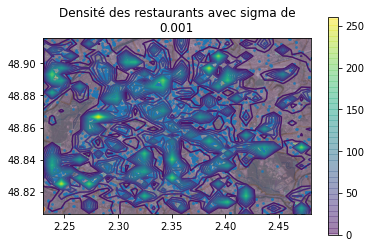

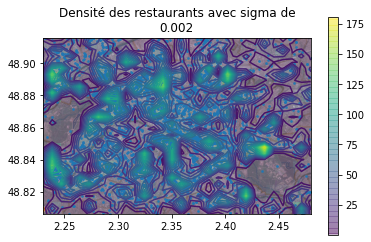

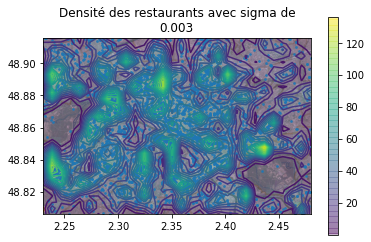

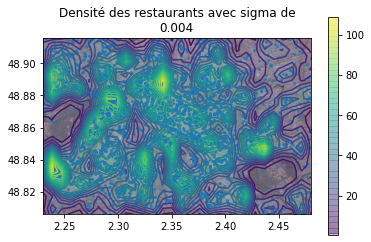

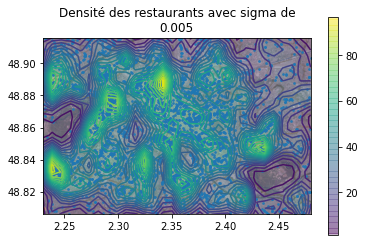

In [108]:
for s in np.arange(0.001, 0.006, 0.001):
    h = KernelDensity(kernel=kernel_gaussian,sigma=s)
    h.fit(geo_rest)
    title = "Densité des restaurants avec sigma de\n" + str(s)
    show_density(h, geo_mat, 30, log=False, title = title)

In [ ]:
# TODO : COMMENTER LES RESULTATS

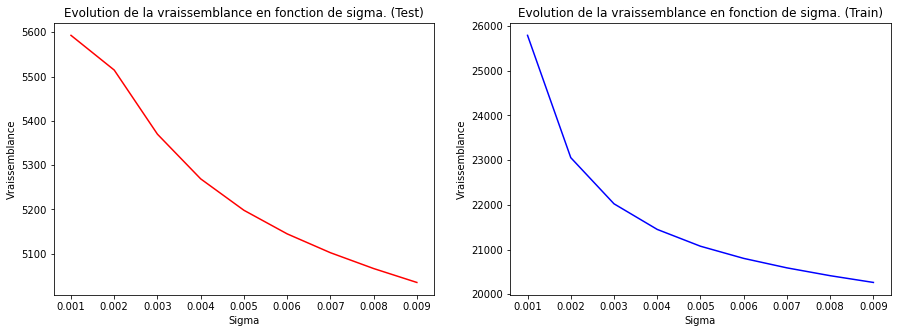

In [155]:
kernel_show(geo_rest, sigma = 0.001, start = 0.001, end = 0.01, step = 0.001, kernel = kernel_gaussian)

In [ ]:
# TODO : COMMENTER LES RESULTATS

# Noyau uniforme

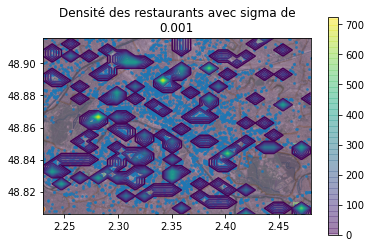

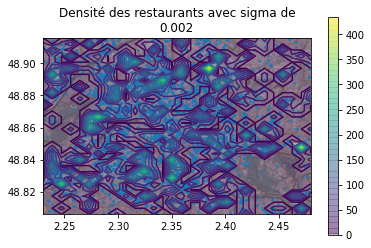

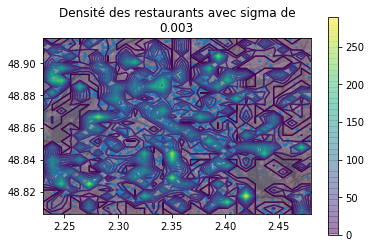

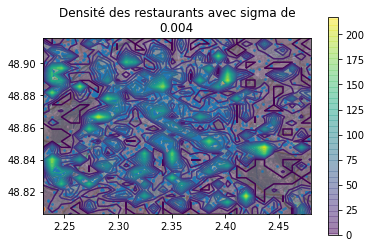

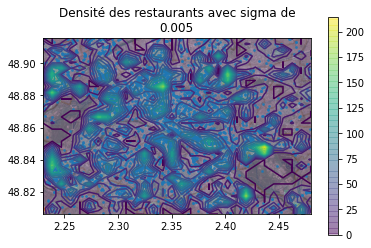

In [109]:
for s in np.arange(0.001, 0.006, 0.001):
    h = KernelDensity(kernel=kernel_uniform,sigma=s)
    h.fit(geo_rest)
    title = "Densité des restaurants avec sigma de\n" + str(s)
    show_density(h, geo_mat, 30, log=False, title = title)

In [ ]:
# TODO : COMMENTER LES RESULTATS

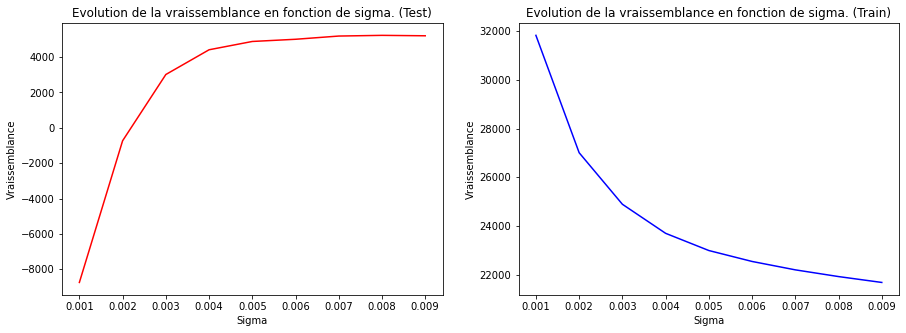

In [98]:
kernel_show(geo_rest, sigma = 0.001, start = 0.001, end = 0.01, step = 0.001, kernel = kernel_uniform)

In [ ]:
# TODO : COMMENTER LES RESULTATS

# Régression par Nadaraya-Watson

In [83]:
 class Nadaraya(Density):
    def __init__(self,kernel = None,sigma = 0):
        Density.__init__(self)
        self.kernel = kernel
        self.sigma = sigma
        
    def fit(self, x, y):
        self.x = x
        self.y = y
        
    def score(self,x,y):
        return np.sum((self.predict(x) - y)**2)
    
    def predict(self,data):
        liste = []
        for d in data:
            t = np.sum(self.kernel((d -self.x)/self.sigma))
            if t == 0:
                liste.append(-1)
            else:
                liste.append(np.sum(self.y*self.kernel((d -self.x)/self.sigma)/t))
        l = np.array(liste)
        return l

    
def kernel_uniform(data):
    res = np.all(abs(data) <= 1 / 2, 1)
    return np.multiply(res,1)
def kernel_gaussian(data):
    return (2*np.pi)**(-len(data[0])/2)*np.exp(-0.5*np.sum(data**2,axis=1))
              

In [156]:
def nadaraya_show(geo_mat, notes, sigma = 0.001, start = 0.001, end = 0.005, step = 0.001, kernel = kernel_gaussian):
    
    X_train, X_test, notes_train, notes_test = train_test_split(geo_mat,notes, test_size=0.2, random_state=42)
    s_test = []
    s_train = []
    for sigma in np.arange(start,end,step):    

        d = Nadaraya(kernel,sigma)
        d.fit(X_train, notes_train)
        score = d.score(X_test,notes_test)
        s_test += [score]
        score = d.score(X_train,notes_train)
        s_train += [score]
        
    _, ax = plt.subplots(ncols=2,nrows=1,figsize=(15, 5))
    ax[0].set_title("Evolution de la vraissemblance en fonction de sigma. (Test)")
    ax[0].set_ylabel("Erreur")
    ax[0].set_xlabel("Sigma")
    ax[0].plot(np.arange(start,end,step),s_test,color="red")
    
    
    ax[1].set_title("Evolution de la vraissemblance en fonction de sigma. (Train)")
    ax[1].set_ylabel("Erreur")
    ax[1].set_xlabel("Sigma")
    ax[1].plot(np.arange(start,end,step),s_train,color="blue")
    plt.show()

In [157]:
geo_rest, notes_rest = load_poi("restaurant")

# Noyau Gaussien

In [126]:
sigma = 0.001
h = Nadaraya(kernel=kernel_gaussian,sigma=sigma)
h.fit(geo_rest[5:],notes_rest[5:])

print('Les notes originales : ', notes_rest[0:5])
print('Les notes prédites : ', h.predict(geo_rest[0:5]))


Les notes originales :  [4.1 3.5 3.5 3.  4.4]
Les notes prédites :  [3.9963703  4.09995046 3.81485475 3.15818368 4.05092229]


In [ ]:
# TODO : COMMENTER LES RESULTATS

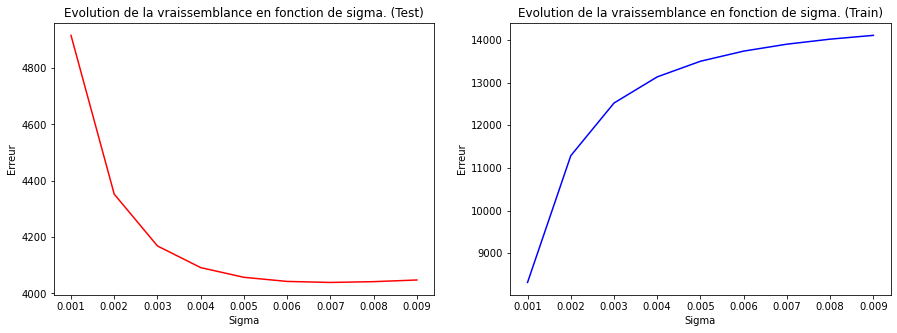

In [158]:
nadaraya_show(geo_rest, notes_rest, sigma = 0.001, start = 0.001, end = 0.01, step = 0.001, kernel = kernel_gaussian)

In [ ]:
# TODO : COMMENTER LES RESULTATS

# Noyau Uniforme

In [127]:
sigma = 0.001
h = Nadaraya(kernel=kernel_uniform,sigma=sigma)
h.fit(geo_rest[5:],notes_rest[5:])

print('Les notes originales : ', notes_rest[0:5])
print('Les notes prédites : ', h.predict(geo_rest[0:5]))


Les notes originales :  [4.1 3.5 3.5 3.  4.4]
Les notes prédites :  [3.95       3.75       3.45       3.8        4.03333333]


In [ ]:
# TODO : COMMENTER LES RESULTATS

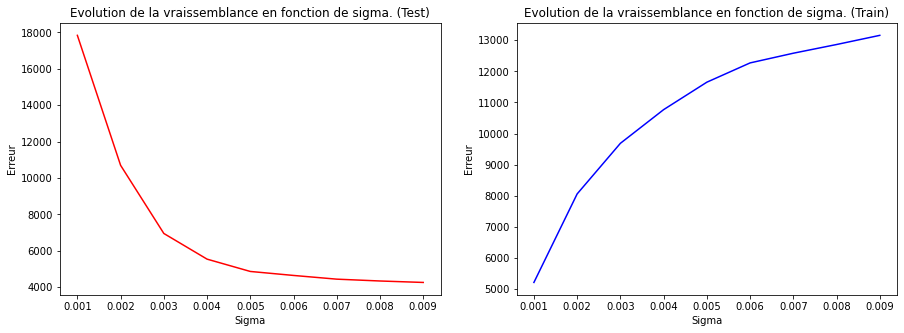

In [115]:
nadaraya_show(geo_rest, notes_rest, sigma = 0.001, start = 0.001, end = 0.01, step = 0.001, kernel = kernel_uniform)

In [ ]:
# TODO : COMMENTER LES RESULTATS

# Used Functions

In [9]:
def get_density2D(f,data,steps=100):
    """ Calcule la densité en chaque case d'une grille steps x steps dont les bornes sont calculées à partir du min/max de data. Renvoie la grille estimée et la discrétisation sur chaque axe.
    """
    xmin, xmax = data[:,0].min(), data[:,0].max()
    ymin, ymax = data[:,1].min(), data[:,1].max()
    xlin,ylin = np.linspace(xmin,xmax,steps),np.linspace(ymin,ymax,steps)
    xx, yy = np.meshgrid(xlin,ylin)
    grid = np.c_[xx.ravel(), yy.ravel()]
    res = f.predict(grid).reshape(steps, steps)
    return res, xlin, ylin

In [29]:
def show_density(f, data, steps=100, log=False, title = None):
    """ Dessine la densité f et ses courbes de niveau sur une grille 2D calculée à partir de data, avec un pas de discrétisation de steps. Le paramètre log permet d'afficher la log densité plutôt que la densité brute
    """
    res, xlin, ylin = get_density2D(f, data, steps)
    xx, yy = np.meshgrid(xlin, ylin)
    plt.figure()
    plt.title(title)
    show_img()
    if log:
        res = np.log(res+1e-10)
    plt.scatter(data[:, 0], data[:, 1], alpha=0.8, s=3)
    show_img(res)
    plt.colorbar()
    plt.contour(xx, yy, res, 20)

In [11]:
def show_img(img=parismap):
    """ Affiche une matrice ou une image selon les coordonnées de la carte de Paris.
    """
    origin = "lower" if len(img.shape) == 2 else "upper"
    alpha = 0.3 if len(img.shape) == 2 else 1.
    plt.imshow(img, extent=coords, aspect=1.5, origin=origin, alpha=alpha)
    ## extent pour controler l'echelle du plan

In [12]:
def load_poi(typepoi,fn=POI_FILENAME):
    """ Dictionaire POI, clé : type de POI, valeur : dictionnaire des POIs de ce type : (id_POI, [coordonnées, note, nom, type, prix])
    
    Liste des POIs : furniture_store, laundry, bakery, cafe, home_goods_store, 
    clothing_store, atm, lodging, night_club, convenience_store, restaurant, bar
    """
    poidata = pickle.load(open(fn, "rb"))
    data = np.array([[v[1][0][1],v[1][0][0]] for v in sorted(poidata[typepoi].items())])
    note = np.array([v[1][1] for v in sorted(poidata[typepoi].items())])
    return data,note

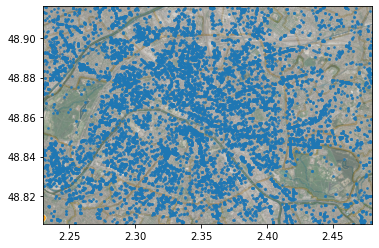

In [13]:
geo_mat1, _ = load_poi("bar")
geo_mat2, _ = load_poi("restaurant")
geo_mat = np.concatenate((geo_mat1,geo_mat2))


geo_night, _ = load_poi("night_club")

# Affiche la carte de Paris
show_img()
# Affiche les POIs
plt.scatter(geo_mat[:,0],geo_mat[:,1],alpha=0.8,s=3)
